<table align="left">
  <td>
    <a href="https://colab.research.google.com/drive/1d8lmQCL40i0rGj_qMFjj5dUXdQYR_ixe" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

---

# **Licencia**

**Autor**: Juan Francisco Puentes Calvo

**Licencia**: GPL v3 (https://www.gnu.org/licenses/gpl-3.0.html)


# **Reconocimientos**

* Ninguno, por ahora.

---

## Reconocimiento de gestos en las manos

**Esta celda se ejecuta en un Jupyter local, para tener acceso a la webcam.**

In [6]:
!pip -q install ipywidgets jupyter-ui-poll mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 17.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


In [ ]:
# prompt: Crea un interfaz que abra la cámara con varios botones. Habrá en total 3 botones, etiquetados como piedra, papel y tijera. Al pulsar cualquiera de estos botones se almacenará una imagen de nombre "<etiqueta><número>.png", en el subdirectorio "manos", donde <etiqueta> es la etiqueta del botón y <número> es un contador. La webcam permanecerá abierta hasta que se pulse "q".

import cv2
import ipywidgets as widgets
from IPython.display import display
import os
from jupyter_ui_poll import ui_events;

# Crea el directorio "manos" si no existe
if not os.path.exists("manos"):
    os.makedirs("manos")

# Contadores para cada gesto
contador_piedra = 0
contador_papel = 0
contador_tijera = 0

# Función para capturar y guardar una imagen
def capturar_imagen(etiqueta):
    global cap, contador_piedra, contador_papel, contador_tijera

    # Incrementa el contador correspondiente
    if etiqueta == "piedra":
        contador_piedra += 1
        nombre_archivo = f"manos/piedra{contador_piedra}.png"
    elif etiqueta == "papel":
        contador_papel += 1
        nombre_archivo = f"manos/papel{contador_papel}.png"
    elif etiqueta == "tijera":
        contador_tijera += 1
        nombre_archivo = f"manos/tijera{contador_tijera}.png"

    # Captura la imagen
    ret, frame = cap.read()
    if ret:
        cv2.imwrite(nombre_archivo, frame)
        print(f"Imagen guardada como {nombre_archivo}")

# Crea los botones
boton_piedra = widgets.Button(description="Piedra")
boton_papel = widgets.Button(description="Papel")
boton_tijera = widgets.Button(description="Tijera")

# Define las funciones para manejar los eventos de los botones
def on_click_piedra(b):
    capturar_imagen("piedra")
def on_click_papel(b):
    capturar_imagen("papel")
def on_click_tijera(b):
    capturar_imagen("tijera")

# Asigna las funciones a los eventos de los botones
boton_piedra.on_click(on_click_piedra)
boton_papel.on_click(on_click_papel)
boton_tijera.on_click(on_click_tijera)

# Muestra los botones
display(boton_piedra, boton_papel, boton_tijera)

# Abre la cámara
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("No se pudo abrir la cámara")
    cap.release()
else:
    print("Cámara abierta correctamente")

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

    # Bucle principal
    while True:
        ret, frame = cap.read()
        if ret:
            cv2.imshow("Webcam", frame)
            with ui_events() as poll: poll(10)
        else:
            break
        # Espera la tecla 'q' para salir
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Libera los recursos
    cap.release()
    cv2.destroyAllWindows()


In [ ]:
# prompt: En el subdirectoprio "manos" hay imágenes, cada una de una mano. Busca la imagen llamada "papel105.png", aplicale una identificación de gesto usando mediapipe y muestra la imagen con los puntos de referencia.

import mediapipe as mp
import cv2

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Carga la imagen
imagen_path = "manos/papel105.png"
imagen = cv2.imread(imagen_path)

# Inicializa el modelo de detección de manos
with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
    # Procesa la imagen
    resultados = hands.process(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))

    # Dibuja los puntos de referencia si se detectaron manos
    if resultados.multi_hand_landmarks:
        for hand_landmarks in resultados.multi_hand_landmarks:
            mp_drawing.draw_landmarks(imagen, hand_landmarks, mp_hands.HAND_CONNECTIONS)

# Muestra la imagen con los puntos de referencia
cv2.imshow("Imagen con puntos de referencia", imagen)
cv2.waitKey(0)
cv2.destroyAllWindows()


I0000 00:00:1723470600.467029    5710 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1723470600.544901   30058 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce RTX 4070/PCIe/SSE2
W0000 00:00:1723470600.549030   30045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1723470600.556457   30044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Los nombres de los ficheros de cada imagen es del tipo "<label><number>.png". Por ejemplo "papel43.png".

Para extraer la etiqueta hay que eliminar la extensión y el número.

---

Para cada punto de referencia hay que calcular la distancia euclídea de este a otro, en este caso a la muñeca.
Así pues el vector de características es la distancia de cada punto de referencia a la muñeca.

In [ ]:
# prompt: En el subdirectoprio "manos" hay imágenes, cada una de una mano. Para cada una de ellas haz una identificación del gesto usando mediapipe, obten los puntos de referencia de la mano, calcula su distancia respecto al punto que representa la muñeca. Almacena cada uno de estos vectores en un Dataframe. La última columna de cada fila es la etiqueta. No muestres nada.

import pandas as pd

# Inicializa el modelo de detección de manos
with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
    # Lista para almacenar los vectores de características y etiquetas
    datos = []

    # Recorre las imágenes en el directorio "manos"
    for filename in os.listdir("manos"):
        if filename.endswith(".png"):
            # Extrae la etiqueta del nombre del archivo
            etiqueta = filename.split('.')[0][:-1]
            etiqueta = etiqueta.rstrip('0123456789')

            # Carga la imagen
            imagen_path = os.path.join("manos", filename)
            imagen = cv2.imread(imagen_path)

            # Procesa la imagen
            resultados = hands.process(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))

            # Obtiene los puntos de referencia si se detectaron manos
            if resultados.multi_hand_landmarks:
                for hand_landmarks in resultados.multi_hand_landmarks:
                    # Calcula la distancia de cada punto de referencia a la muñeca
                    vector_caracteristicas = []
                    muñeca = hand_landmarks.landmark[mp_hands.HandLandmark.WRIST]
                    for punto in hand_landmarks.landmark:
                        distancia = ((punto.x - muñeca.x)**2 + (punto.y - muñeca.y)**2 + (punto.z - muñeca.z)**2)**0.5
                        vector_caracteristicas.append(distancia)

                    # Agrega el vector de características y la etiqueta a la lista de datos
                    vector_caracteristicas.append(etiqueta)
                    datos.append(vector_caracteristicas)

# Crea un DataFrame a partir de los datos
columnas = [f"Punto_{i}" for i in range(len(datos[0]) - 1)] + ["Etiqueta"]
df = pd.DataFrame(datos, columns=columnas)


I0000 00:00:1723471967.530564    5710 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1723471967.560790   33693 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce RTX 4070/PCIe/SSE2
W0000 00:00:1723471967.565258   33680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1723471967.571738   33678 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/fran/CODE/iTI2025/.iti2025/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [ ]:
# prompt: Guarda el dataframe 'df' en un fichero llamado 'manos.csv'.

df.to_csv('manos.csv', index=False)


### Dado un dataframe con vectres de características anotados, hacer un clustering

In [1]:
# prompt: Dado un fichero csv referenciado mediante una url, descárgalo, ábreo y muestra info sobre su contenido.

import pandas as pd

# URL del fichero CSV
url = 'https://raw.github.com/FranPuentes/iTI2025/main/data/manos.csv'

# Descarga el fichero CSV
df = pd.read_csv(url)

# Muestra información sobre el contenido del DataFrame
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Punto_0   422 non-null    float64
 1   Punto_1   422 non-null    float64
 2   Punto_2   422 non-null    float64
 3   Punto_3   422 non-null    float64
 4   Punto_4   422 non-null    float64
 5   Punto_5   422 non-null    float64
 6   Punto_6   422 non-null    float64
 7   Punto_7   422 non-null    float64
 8   Punto_8   422 non-null    float64
 9   Punto_9   422 non-null    float64
 10  Punto_10  422 non-null    float64
 11  Punto_11  422 non-null    float64
 12  Punto_12  422 non-null    float64
 13  Punto_13  422 non-null    float64
 14  Punto_14  422 non-null    float64
 15  Punto_15  422 non-null    float64
 16  Punto_16  422 non-null    float64
 17  Punto_17  422 non-null    float64
 18  Punto_18  422 non-null    float64
 19  Punto_19  422 non-null    float64
 20  Punto_20  422 non-null    float6

In [47]:
# prompt: Usando este dataframe entrena un modelo de clustering para 3 clusters usando GaussianMixture, y con TSNE muestra en 3d interactivo su dispersión. Ten en cuenta que la última columna es una etiqueta, no la uses pra clusterizar, pero si para poner un color en cada fila.

import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import plotly.express as px

# Separa las características de las etiquetas
X = df.drop('Etiqueta', axis=1)
y = df['Etiqueta']

# Crea el modelo de clustering
gmm = GaussianMixture(n_components=3)
gmm.fit(X)

# Obtiene las etiquetas de los clusters
labels = gmm.predict(X)

# Reduce la dimensionalidad con TSNE
tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(X)

# Crea un DataFrame con los resultados de TSNE y las etiquetas
df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y', 'z'])
df_tsne['Etiqueta'] = y
df_tsne['Cluster'] = labels

# Muestra la dispersión en 3D interactivo
fig = px.scatter_3d(df_tsne, x='x', y='y', z='z', color='Etiqueta', symbol='Cluster',
                    title='Dispersión de Clusters en 3D')
fig.show()


In [48]:
# prompt: Usando este dataframe entrena un modelo de clustering para 3 clusters usando GaussianMixture, y con TSNE muestra en 2d su dispersión. Ten en cuenta que la última columna es una etiqueta, no la uses pra clusterizar, pero si para poner un color en cada fila.

import pandas as pd
# Separa las características de las etiquetas
X = df.drop('Etiqueta', axis=1)
y = df['Etiqueta']

# Crea el modelo de clustering
gmm = GaussianMixture(n_components=3)
gmm.fit(X)

# Obtiene las etiquetas de los clusters
labels = gmm.predict(X)

# Reduce la dimensionalidad con TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# Crea un DataFrame con los resultados de TSNE y las etiquetas
df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y'])
df_tsne['Etiqueta'] = y
df_tsne['Cluster'] = labels

# Muestra la dispersión en 2D
fig = px.scatter(df_tsne, x='x', y='y', color='Etiqueta', symbol='Cluster',
                 title='Dispersión de Clusters en 2D')
fig.show()


In [55]:
# prompt: Dado el dataframe de gestos de manos, entrena un modelo randomforest para predecir la columna "Etiqueta", un testset de 20 filas aleaorias del dataset.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Separa las características de las etiquetas
X = df.drop('Etiqueta', axis=1)
y = df['Etiqueta']

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, random_state=42)

# Crea el modelo RandomForest
model = RandomForestClassifier()

# Entrena el modelo
model.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcula la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)


Precisión del modelo: 1.0


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning:

SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



array([[[130, 171, 189],
        [130, 171, 189],
        [130, 171, 189],
        ...,
        [151, 182, 200],
        [151, 182, 200],
        [151, 182, 200]],

       [[130, 171, 189],
        [130, 171, 189],
        [130, 171, 189],
        ...,
        [151, 182, 200],
        [151, 182, 200],
        [151, 182, 200]],

       [[130, 171, 189],
        [130, 171, 189],
        [130, 171, 189],
        ...,
        [151, 182, 200],
        [151, 182, 200],
        [151, 182, 200]],

       ...,

       [[ 29,  76,  96],
        [ 29,  76,  96],
        [ 30,  77,  97],
        ...,
        [ 67, 109, 131],
        [ 68, 109, 131],
        [ 68, 109, 131]],

       [[ 29,  76,  96],
        [ 29,  76,  96],
        [ 30,  77,  97],
        ...,
        [ 67, 109, 131],
        [ 68, 109, 131],
        [ 68, 109, 131]],

       [[ 29,  76,  96],
        [ 29,  76,  96],
        [ 30,  77,  97],
        ...,
        [ 67, 109, 131],
        [ 68, 109, 131],
        [ 68, 109, 131]]], dtype=uint8)
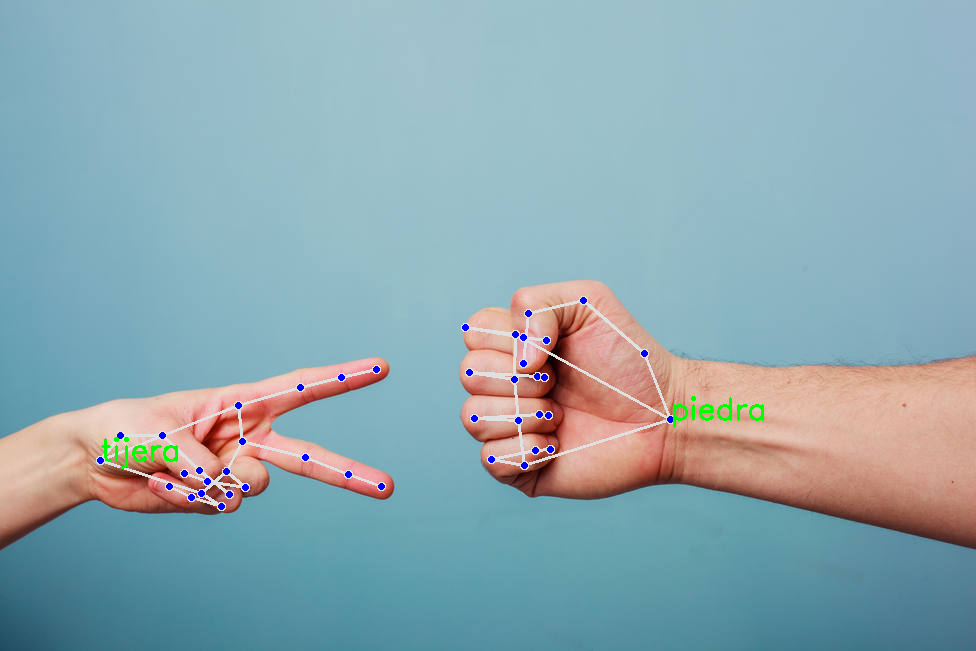

In [58]:
# prompt: Dada una imagen, referenciada mediante una url, y usando el modelo anterior (model), extrae las manos que pueda haber y determina para cada una de ellas su etiqueta (piedra, papel, tijera). Muestra la imagen y la predicción de cada mano.

import cv2
import mediapipe as mp
import numpy as np

def predecir_gesto(url_imagen, model):
    # Descarga la imagen
    !wget -q {url_imagen} -O imagen.jpg

    # Carga la imagen
    imagen = cv2.imread('imagen.jpg')

    # Inicializa el modelo de detección de manos
    with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
        # Procesa la imagen
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        resultados = hands.process(imagen)

        # Obtiene los puntos de referencia si se detectaron manos
        if resultados.multi_hand_landmarks:
            for hand_landmarks in resultados.multi_hand_landmarks:
                # Calcula la distancia de cada punto de referencia a la muñeca
                vector_caracteristicas = []
                muñeca = hand_landmarks.landmark[mp_hands.HandLandmark.WRIST]
                for punto in hand_landmarks.landmark:
                    distancia = ((punto.x - muñeca.x)**2 + (punto.y - muñeca.y)**2 + (punto.z - muñeca.z)**2)**0.5
                    vector_caracteristicas.append(distancia)

                # Realiza la predicción
                prediccion = model.predict([vector_caracteristicas])[0]

                # Dibuja los puntos de referencia y la predicción
                mp_drawing.draw_landmarks(imagen, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                cv2.putText(imagen, prediccion, (int(muñeca.x * imagen.shape[1]), int(muñeca.y * imagen.shape[0])),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Muestra la imagen con las predicciones
    display(imagen)

# Ejemplo de uso
url_imagen = 'https://cope-cdnmed.cope.es/resources/jpg/6/9/1590047761696.jpg'
predecir_gesto(url_imagen, model)
